# Tema 6

Sa se creeze si antreneze o retea de tip convolutional pentru setul de date [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html). Intrarea este RGB, de forma 32 x 32 x 3. 

Cerinte:
1. Efectuati minim 50 de epoci de instruire. 
1. Reprezentati grafic evolutia functiei de cost si a acuratetei, masurate pe setul de antrenare si de validare, la finalul fiecarei epoci.
1. Acuratetea unui model neantrenat este de in medie 1% (se decide aleator o clasa pentru fiecare input). Modelul vostru va trebui sa ajunga mult peste acest prag de baza. 
1. Odata gasit arhitectura care performeaza peste 1%, incercati 3 valori diferite pentru hiperparametrul learning rate. Modelul va fi antrenat pe 45000 de imagini alese aleator din setul de antrenare si validat pe restul de 5000 imagini din setul de antrenare. Acel LR care produce cea mai buna acuratete pe setul de validare va fi folosit pentru antrenarea peste cele 45000 imagini de antrenare + 5000 imagini de testare si in final testat pe setul de testare de 10000 de imagini. Setul de testare nu se va folosi in etapa de antrenare sau de validare (cautare de LR optimal). 


Nota: pentru desenarea in timp real a graficelor puteti folosi tensorboard [https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html), [https://towardsdatascience.com/a-complete-guide-to-using-tensorboard-with-pytorch-53cb2301e8c3](https://towardsdatascience.com/a-complete-guide-to-using-tensorboard-with-pytorch-53cb2301e8c3). Reprezentarea in timp real e utila, pentru a putea opri experimentele care nu arata o scadere a loss-ului dupa primele 5 epoci.

Tema va fi predata pana in 24 mai ora 23 pe elearning. Notarea ei se va face doar in prezenta studentului.

Urmariti documentul pentru completari ulterioare.

## Import de pachete

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.12.1  Device: cpu


In [97]:
!pip install torch-summary
from torchsummary import summary

!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter

## Pregatire dataset, dataloader

In [98]:
# se poate ajusta dimensiunea batchului
batch_size = 16

train_augmentations = transforms.Compose([transforms.RandomGrayscale(0.2),
                                          transforms.RandomHorizontalFlip(0.5),
                                          transforms.RandomVerticalFlip(0.2),
                                          transforms.RandomRotation(30),
                                          transforms.RandomAdjustSharpness(0.4),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                         ])

test_augmentations = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
                                       )

train_dataset = datasets.CIFAR100('./data', 
                               train=True, 
                               download=True, 
                               transform=train_augmentations)

assert len(train_dataset) == 50000

test_dataset = datasets.CIFAR100('./data', 
                                    train=False, 
                                    transform=test_augmentations)

assert len(test_dataset) == 10000



Files already downloaded and verified


In [99]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=2
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=2
                                          )

Nota: daca celula de plot produce eroare, atunci se foloseste workaround de la [https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial](https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial):"

In [100]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [101]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

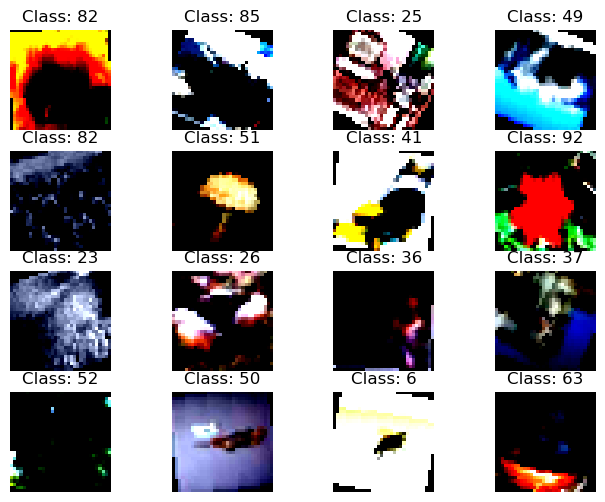

In [102]:
pltsize=1
plt.figure(figsize=(8, 6))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(3,32,32).transpose(1,2,0))
    plt.title('Class: '+str(y_train[i].item()))

## Functii: antrenare, validare, desenare

Define test function

In [103]:
@torch.no_grad()
def test(
        model: nn.Module,
        criterion: nn.CrossEntropyLoss,
        loader: torch.utils.data.DataLoader,
        device: torch.device
) -> Tuple[float, float]:
    model.eval()
    accuracy, test_loss = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        test_loss += criterion(y_hat, y).item() * x.shape[0]
        _, predicted = torch.max(y_hat, axis=1)
        accuracy += (predicted == y).sum().item()
    accuracy /= len(loader.dataset)
    test_loss /= len(loader.dataset)
    return accuracy, test_loss

define plot function

In [104]:
def plot(x_epochs, train_loss, test_loss, test_acc):
    plt.title('Loss curves')
    plt.plot(x_epochs, train_loss, 'red', label='Train loss')
    plt.plot(x_epochs, test_loss, 'green', label='Test loss')
    plt.legend(loc='best')
    plt.show()

    plt.title('Test accuracy')
    plt.plot(x_epochs, test_acc)
    plt.show()

define train loop

In [105]:
def train(model: nn.Module,
          epochs: int,
          criterion: nn.CrossEntropyLoss,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          device: torch.device) -> None:
    train_losses = []
    test_accuracies = []
    test_losses = []
    test_accuracy_untrained, test_loss_untrained = test(model, criterion, test_loader, device)
    print(f'On untrained model, test set: acc={test_accuracy_untrained*100:.2f}, loss={test_loss_untrained:.4f}')

    for epoch in range(1, epochs + 1):
        model.train()
        running_train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            running_train_loss += loss.item() * x.shape[0]

            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(running_train_loss / len(train_loader.dataset))
        test_accuracy, test_loss = test(model, criterion, test_loader, device)
        print(f'Epoch {epoch}/{epochs}, train set: loss={train_losses[-1]:.4f}')
        print(f'Epoch {epoch}/{epochs}, test set: acc={test_accuracy*100:.2f}%, loss={test_loss:.4f}')
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    x_epochs = list(range(1, epochs+1))
    plot(x_epochs, train_losses, test_losses, test_accuracies)

Definiti in mod convenabil functii de antrenare si de validare. Puteti reutiliza cod din notebook-urile anterioare. 

## Definire model

In [106]:
class ConvNet(nn.Module):
    def __init__(self, classes: int):
        super(ConvNet, self).__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.05, affine=True),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.05, affine=True),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 64 x 16 x 16
            nn.Dropout(0.15)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128, eps=1e-05, momentum=0.05, affine=True),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2), # 128 x 8 x 8
            nn.Dropout(0.1)
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256, eps=1e-05, momentum=0.05, affine=True),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=1),
            nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.05, affine=True),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2), # 512 x 4 x 4
            nn.Dropout(0.15)
        )
        self.conv_layer_4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1), #512 x 2 x 2
            nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.05, affine=True),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2), # 512 x 1 x 1
            nn.Dropout(0.2)
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.Sigmoid(),
            nn.Linear(in_features=256, out_features=124),
            nn.Sigmoid(),
            nn.Linear(in_features=124, out_features=classes)
        )
    def forward(self, x):
        out = self.conv_layer_1(x)
        out = self.conv_layer_2(out)
        out = self.conv_layer_3(out)
        out = self.conv_layer_4(out)
        out = out.view(-1, 512)
        out = self.fully_connected(out)
        return out

## Antrenare si validare

In [107]:
import torchsummary

model = ConvNet(classes=100)
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       448
|    └─BatchNorm2d: 2-2                  32
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       9,280
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
|    └─MaxPool2d: 2-7                    --
|    └─Dropout: 2-8                      --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-9                       73,856
|    └─BatchNorm2d: 2-10                 256
|    └─ReLU: 2-11                        --
|    └─MaxPool2d: 2-12                   --
|    └─Dropout: 2-13                     --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-14                      295,168
|    └─BatchNorm2d: 2-15                 512
|    └─ReLU: 2-16                        --
|    └─Conv2d: 2-17                      131,584
|    └─BatchNorm2d: 2-18                 1,024
|  

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       448
|    └─BatchNorm2d: 2-2                  32
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       9,280
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
|    └─MaxPool2d: 2-7                    --
|    └─Dropout: 2-8                      --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-9                       73,856
|    └─BatchNorm2d: 2-10                 256
|    └─ReLU: 2-11                        --
|    └─MaxPool2d: 2-12                   --
|    └─Dropout: 2-13                     --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-14                      295,168
|    └─BatchNorm2d: 2-15                 512
|    └─ReLU: 2-16                        --
|    └─Conv2d: 2-17                      131,584
|    └─BatchNorm2d: 2-18                 1,024
|  

In [108]:

epochs = 50
lr = 0.01
momentum = 0.9
weight_decay = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

In [109]:
train(model, epochs, criterion, train_loader, test_loader, device)

On untrained model, test set: acc=1.00, loss=4.6448
Epoch 1/50, train set: loss=4.3845
Epoch 1/50, test set: acc=5.23%, loss=4.0866
Epoch 2/50, train set: loss=4.0317
Epoch 2/50, test set: acc=9.85%, loss=3.7020
Epoch 3/50, train set: loss=3.7879
Epoch 3/50, test set: acc=14.58%, loss=3.4917
Epoch 4/50, train set: loss=3.5976
Epoch 4/50, test set: acc=18.63%, loss=3.2481
Epoch 5/50, train set: loss=3.4205
Epoch 5/50, test set: acc=21.69%, loss=3.1024
Epoch 6/50, train set: loss=3.2739
Epoch 6/50, test set: acc=26.06%, loss=2.8744


KeyboardInterrupt: 

Se vor tipari si prezenta ploturi (loss, acuratete) pe seturile de antrenare si validare la finalul fiecarei epoci.